<a href="https://colab.research.google.com/github/stuti2504-hub/Task-08/blob/main/Task_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model evaluation on test set:
  Accuracy : 0.5763
  Precision: 0.5702
  Recall   : 0.3635
  AUC      : 0.5948

              precision    recall  f1-score   support

           0     0.5789    0.7615    0.6578     16040
           1     0.5702    0.3635    0.4440     13960

    accuracy                         0.5763     30000
   macro avg     0.5746    0.5625    0.5509     30000
weighted avg     0.5749    0.5763    0.5583     30000

Top features by importance:
recency_days               0.152678
avg_delivery_delay_days    0.151156
total_spend                0.115491
rfm_score                  0.115094
avg_order_value            0.088120
engagement_score           0.077464
avg_session_secs           0.075112
avg_resolution_hrs         0.074620
age                        0.061236
app_opens_30d              0.036087
dtype: float64


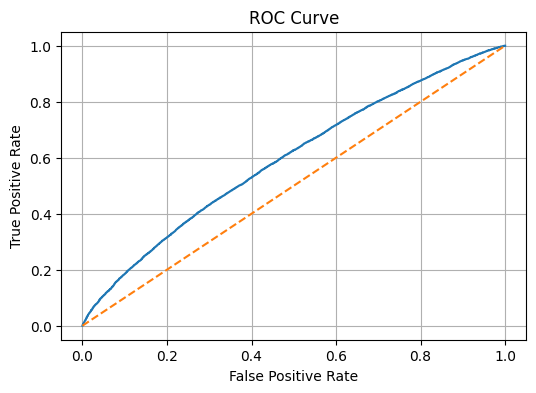

At-risk customers (top 10 sample):
       customer_id  proba_churn  total_spend  orders_last_year
4438          4439     0.807967      1815.27                 2
1878          1879     0.804368      1088.84                 1
498            499     0.801537       843.56                 1
2011          2012     0.798232      3298.40                 2
15309        15310     0.796043      1923.69                 2
48175        48176     0.795323       120.86                 0
63973        63974     0.791416      1619.92                 1
69763        69764     0.791279      -169.58                 0
95226        95227     0.790529      3242.27                 3
78179        78180     0.790383       233.13                 0
Cluster summary:
         orders_last_year  total_spend  recency_days  app_opens_30d  \
cluster                                                               
0                    2.16      2963.31         59.11           6.36   
1                    1.48      1666.38    

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pickle
import os

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# 1) Generate synthetic dataset
n = 120_000
customer_id = np.arange(1, n+1)

age = np.random.randint(18, 70, size=n)
gender = np.random.choice(['M', 'F', 'Other'], size=n, p=[0.48, 0.5, 0.02])
city_tier = np.random.choice(['Tier1', 'Tier2', 'Tier3'], size=n, p=[0.35, 0.45, 0.20])

orders_last_year = np.random.poisson(lam=2.4, size=n)
avg_order_value = np.round(np.random.normal(loc=1500, scale=600, size=n).clip(100, 20000), 2)
total_spend = orders_last_year * avg_order_value + np.random.normal(0, 200, size=n)

recency = np.random.exponential(scale=60, size=n).astype(int)
app_opens_last_30d = np.random.poisson(lam=5, size=n)
avg_session_secs = np.round(np.random.exponential(scale=180, size=n)).astype(int)

support_tickets_last_90d = np.random.poisson(lam=0.25, size=n)
avg_resolution_hours = np.random.normal(loc=20, scale=12, size=n).clip(1, 200)
refunds = np.random.binomial(n=orders_last_year, p=0.03)
refund_ratio = np.divide(refunds, orders_last_year, out=np.zeros_like(refunds,dtype=float), where=orders_last_year!=0)

avg_delivery_delay_days = np.round(np.random.exponential(scale=1.2, size=n) - 0.3, 2)
avg_delivery_delay_days = np.clip(avg_delivery_delay_days, 0, 20)

# synthetic churn probability (constructive formula)
score = (
    0.03*recency +
    0.8*support_tickets_last_90d +
    1.6*avg_delivery_delay_days -
    0.0006*total_spend -
    0.05*orders_last_year -
    0.01*app_opens_last_30d
)
prob = 1 / (1 + np.exp(-0.12*(score - np.percentile(score, 70))))
prob = np.clip(prob + np.random.normal(0, 0.08, size=n), 0, 1)

churn = np.random.binomial(1, prob)

df = pd.DataFrame({
    'customer_id': customer_id,
    'age': age,
    'gender': gender,
    'city_tier': city_tier,
    'orders_last_year': orders_last_year,
    'avg_order_value': avg_order_value,
    'total_spend': total_spend.round(2),
    'recency_days': recency,
    'app_opens_30d': app_opens_last_30d,
    'avg_session_secs': avg_session_secs,
    'support_tickets_90d': support_tickets_last_90d,
    'avg_resolution_hrs': avg_resolution_hours.round(1),
    'refunds': refunds,
    'refund_ratio': refund_ratio.round(3),
    'avg_delivery_delay_days': avg_delivery_delay_days,
    'churn': churn
})

# 2) Feature engineering
df['recency_rank'] = df['recency_days'].rank(method='dense', ascending=False)
df['frequency_rank'] = df['orders_last_year'].rank(method='dense', ascending=True)
df['monetary_rank'] = df['total_spend'].rank(method='dense', ascending=True)
df['rfm_score'] = (df['recency_rank'] + df['frequency_rank'] + df['monetary_rank']) / 3
df['engagement_score'] = (df['app_opens_30d'] + (df['avg_session_secs']/60)).clip(lower=0)
df['refund_ratio'] = df['refund_ratio'].fillna(0)

feature_cols = [
    'age','orders_last_year','avg_order_value','total_spend','recency_days',
    'app_opens_30d','avg_session_secs','support_tickets_90d','avg_resolution_hrs',
    'refund_ratio','avg_delivery_delay_days','rfm_score','engagement_score'
]

X = df[feature_cols]
y = df['churn']

# 3) Train-test split and scaling
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4) Train Random Forest
clf = RandomForestClassifier(n_estimators=200, max_depth=12, random_state=RANDOM_SEED, n_jobs=-1)
clf.fit(X_train, y_train)

# 5) Evaluate
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:,1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)

print("Model evaluation on test set:")
print(f"  Accuracy : {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall   : {rec:.4f}")
print(f"  AUC      : {auc:.4f}\n")
print(classification_report(y_test, y_pred, digits=4))

# 6) Feature importance
importances = pd.Series(clf.feature_importances_, index=feature_cols).sort_values(ascending=False)
print("Top features by importance:")
print(importances.head(10))

# 7) ROC plot (matplotlib)
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

# 8) At-risk list
X_test_copy = X_test.copy()
X_test_copy['proba_churn'] = y_proba
X_test_copy['customer_id'] = df.loc[X_test.index, 'customer_id'].values
X_test_copy['total_spend'] = df.loc[X_test.index, 'total_spend'].values
X_test_copy['orders_last_year'] = df.loc[X_test.index, 'orders_last_year'].values
at_risk = X_test_copy[X_test_copy['proba_churn'] > 0.6].sort_values('proba_churn', ascending=False)
print("At-risk customers (top 10 sample):")
print(at_risk.head(10)[['customer_id','proba_churn','total_spend','orders_last_year']])

# 9) KMeans segmentation (4 clusters)
kmeans = KMeans(n_clusters=4, random_state=RANDOM_SEED, n_init=10)
clusters = kmeans.fit_predict(X_train_scaled)
sample_map = pd.DataFrame({
    'customer_id': df.loc[X_train.index, 'customer_id'].values,
    'cluster': clusters
})
cluster_summary = pd.concat([sample_map, X_train.reset_index(drop=True)], axis=1).groupby('cluster').agg({
    'orders_last_year':'mean','total_spend':'mean','recency_days':'mean','app_opens_30d':'mean','support_tickets_90d':'mean'
}).round(2)
print("Cluster summary:")
print(cluster_summary)

# 10) Save model, scaler, and a CSV report
os.makedirs('outputs', exist_ok=True)
model_path = 'outputs/churn_rf_model.pkl'
scaler_path = 'outputs/scaler.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(clf, f)
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

# report (sample)
report = X_test_copy[['customer_id','proba_churn','total_spend','orders_last_year']].copy()
report['predicted_churn'] = (report['proba_churn'] > 0.5).astype(int)
report_path = 'outputs/churn_report_sample.csv'
report.sample(100, random_state=RANDOM_SEED).to_csv(report_path, index=False)

print(f"Saved model to: {model_path}")
print(f"Saved report to: {report_path}")
